/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


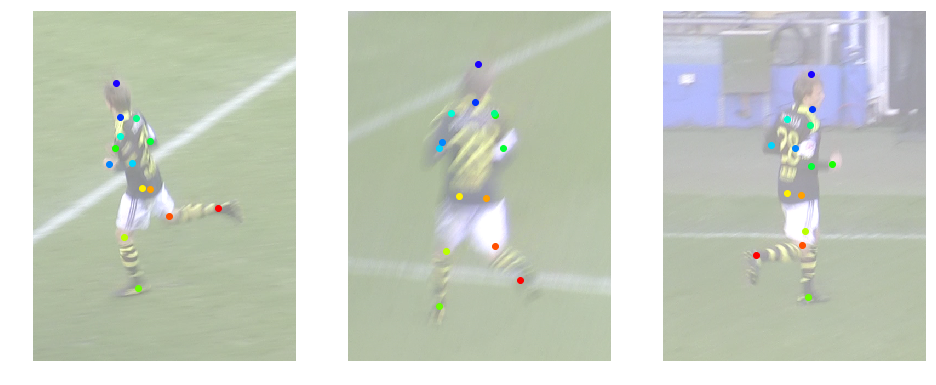

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth

from mvpose.algorithm import settings

params = settings.get_settings(scale_to_mm=1000, max_epi_distance=20)

colors = cs.lincolor(20).astype('float32')/255
FRAME = 9
data_root = Settings['data_root']
seq1_zipname = 'player2sequence1.zip'
seq1_dir = 'Sequence 1'
Im, Calib, pos2d, pos3d = kth.get(
    data_root, seq1_zipname, seq1_dir, FRAME, player=2)

fig = plt.figure(figsize=(16,8))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    joints = pos2d[:,:,cid]
    for jid, (x,y) in enumerate(joints):
        ax.scatter(x,y,color=colors[jid])

plt.show()

In [2]:
from mvpose import pose
from mvpose.algorithm import graphcut
import paf_loader


heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, FRAME, dir='/home/julian/Temp')

_start = time()
Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=params, debug=True)
_end = time()

print('found detections:', len(detections))

step 1: elapsed 0.7962510585784912
step 2: elapsed 0.007215738296508789
step 3: elapsed 0.30305027961730957
-------------------------------------------
Handle transitivity:
	Intra:		 126
	Intra(choice):	 6
	Inter:		 867
	Inter(choice):	 113
-------------------------------------------
	Time =  21445  ms
	result: 0

	Total cost: 139.35650411836937

# valid points:		 38
# invalid points:	 21
step 4: elapsed 21.45197296142578
step 5: elapsed 0.0012674331665039062
found detections: 0


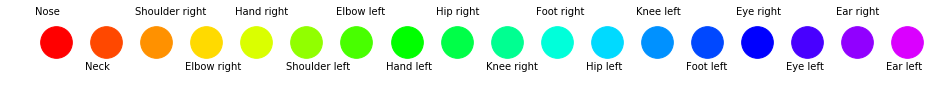

In [3]:
from mvpose.data.default_limbs import DEFAULT_JOINT_NAMES

def plot_colors(n):
    colors = cs.lincolor(n)/255

    fig = plt.figure(figsize=(16,1))
    for jid, name in enumerate(DEFAULT_JOINT_NAMES):
        ax = fig.add_subplot(1, 18,jid+1)
        ax.axis('off')
        ax.set_xlim([-50, 50])
        ax.set_ylim([-50, 50])
        ax.scatter(0, 0, color=colors[jid], s=1000)
        if jid % 2 == 0:
            ax.text(-50, 50, name)
        else:
            ax.text(-50, -50, name)
    plt.show()

plot_colors(22)

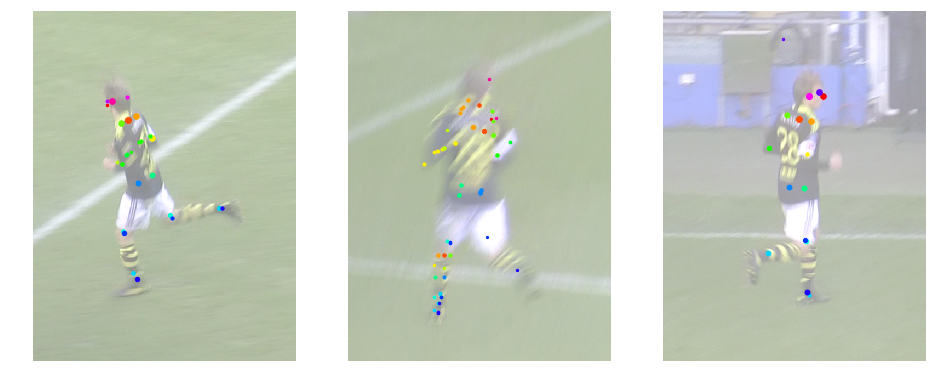

In [4]:
fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    
    for jid in range(Debug.candidates2d.n_joints):
        for x,y,score in Debug.candidates2d.peaks2d_undistorted[cid][jid]:
            ax.scatter(x,y,s=score*50, c=colors[jid])
plt.show()

Cam1 -> Cam0
	point0 [247.15002613  32.16339301  20.70639287  13.40433106   9.76054717
   5.63398082]

Cam2 -> Cam0
	point0 [18.01335591]

Cam0 -> Cam1
	point0 [272.67004592]
	point1 [35.48045146]
	point2 [22.84021844]
	point3 [14.78402884]
	point4 [10.76392947]
	point5 [6.220484]

Cam2 -> Cam1
	point0 [257.92105563]
	point1 [32.22741245]
	point2 [4.02211317]
	point3 [3.74617413]
	point4 [6.44104179]
	point5 [19.40507324]

Cam0 -> Cam2
	point0 [17.3452839]

Cam1 -> Cam2
	point0 [227.22454216  28.38009777   3.5301893    3.31395902   5.68823729
  17.11002892]



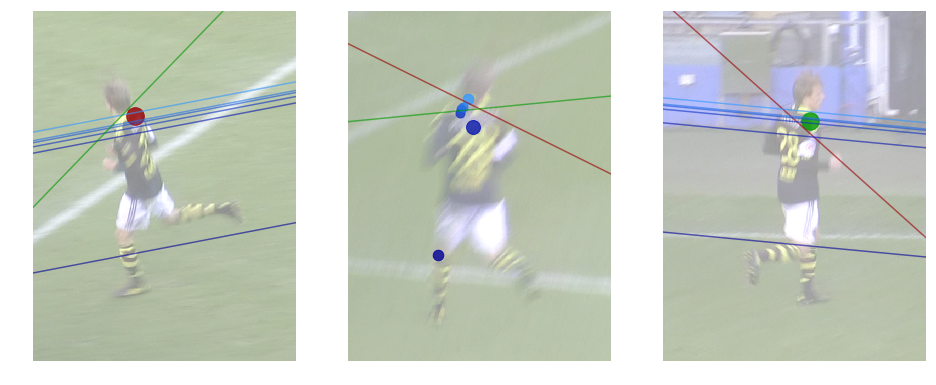

In [5]:
import mvpose.geometry.stereo as stereo
import mvpose.geometry.geometry as gm
import cv2

jid = 2  # shoulder left

#pts_A = Debug.candidates2d.peaks2d_undistorted[cid][jid]


CRANGE_PER_CAM = [
    [(152, 0, 0), (255, 102, 102)],
    [(0, 0, 152), (51, 153, 255)],
    [(0, 152, 0), (102, 255, 102)]
]


fig = plt.figure(figsize=(16,12))
ax_per_cam = []
color_per_cam = []
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3, cid+1)
    ax_per_cam.append(ax)
    ax.set_xlim(0, im.shape[1])
    ax.set_ylim(im.shape[0], 0)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    pts_A = Debug.candidates2d.peaks2d_undistorted[cid][jid]
    
    n = len(pts_A)
    low, high = CRANGE_PER_CAM[cid]
    colors = cs.rangecolor(n, low, high)/255
    color_per_cam.append(colors)
    
    for i, (x,y,w) in enumerate(pts_A):
        ax.scatter(x,y, color=colors[i], s=w*500, alpha=0.8)
    

f = lambda a,b,c,x: (-a*x -c)/b
    
for cid1, cam1 in enumerate(Calib):
    P1 = cam1.P
    pts1 = Debug.candidates2d.peaks2d_undistorted[cid1][jid]
    ax = ax_per_cam[cid1]
    
    for cid2, cam2 in enumerate(Calib):
        if cid1 == cid2:
            continue
        
        P2 = cam2.P
        pts2 = Debug.candidates2d.peaks2d_undistorted[cid2][jid]
        
        F = stereo.get_fundamental_matrix(P1, P2)
        epilines_2to1 = np.squeeze(
            cv2.computeCorrespondEpilines(pts2[:, 0:2], 2, F))
        if len(epilines_2to1.shape) <= 1:
            epilines_2to1 = np.expand_dims(epilines_2to1, axis=0)
        
        for i, (a,b,c) in enumerate(epilines_2to1):
            color = color_per_cam[cid2][i]
            y0 = f(a,b,c,0)
            y1 = f(a,b,c,1000)
            ax.plot([0, 1000], [y0, y1], color=color, alpha=0.6)
        
        print('Cam' + str(cid2) + ' -> Cam' + str(cid1))
        for i, pt1 in enumerate(pts1):

            distance = gm.line_to_point_distance(
                epilines_2to1[:,0], epilines_2to1[:,1], epilines_2to1[:,2], 
                pt1[0], pt1[1])
            print('\tpoint' + str(i), distance)
            
            
        
        print('')
        

plt.show()

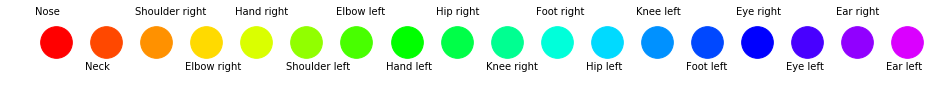

In [6]:
plot_colors(22)

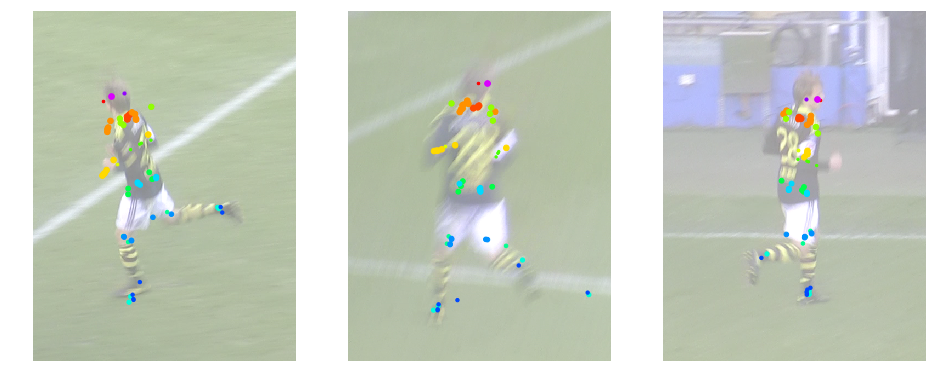

In [7]:
colors = cs.lincolor(22)/255
fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3, cid+1)
    ax.set_xlim(0, im.shape[1])
    ax.set_ylim(im.shape[0], 0)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.triangulation.peaks3d_weighted[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50)

plt.show()

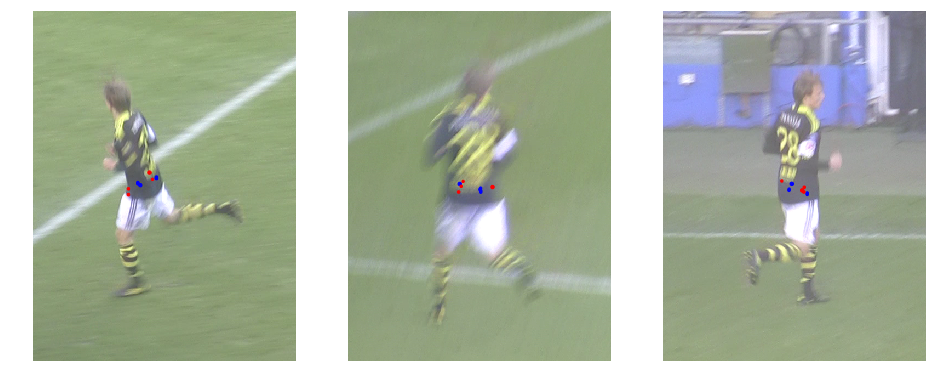

In [8]:
import mvpose.geometry.geometry as gm

HIP_LEFT = 11  # hip left
HIP_RIGHT = 8  # hip right


def plot_joints(JOINTS, colors):
    fig = plt.figure(figsize=(16,12))
    for cid, (im, cam) in enumerate(zip(Im, Calib)):
        ax = fig.add_subplot(1,3, cid+1)
        for jid, J in enumerate(JOINTS):
            ax.axis('off')
            ax.imshow(im, alpha=0.5)
            pts3d_with_w = Debug.triangulation.peaks3d_weighted[J]
            pts3d = pts3d_with_w[:,0:3].astype('float32')
            pts2d = cam.projectPoints_undist(pts3d)
            ax.scatter(pts2d[:,0], pts2d[:,1], 
                       s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50, color=colors[jid])
    
    plt.show()

plot_joints([HIP_LEFT, HIP_RIGHT], ['blue', 'red'])

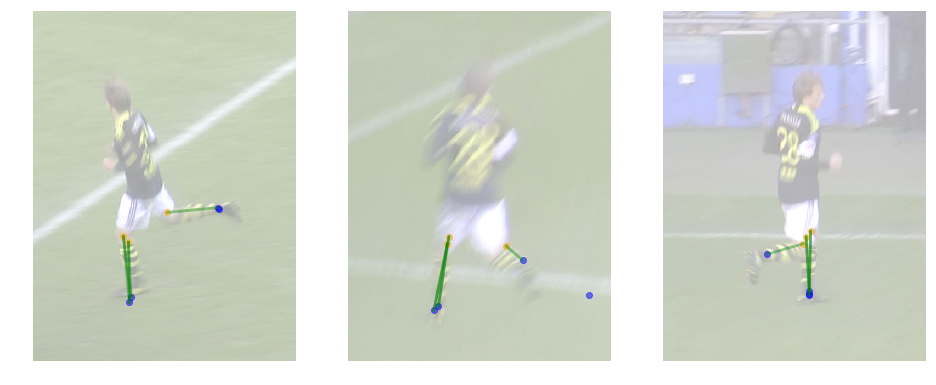

In [9]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

LIMB_ID = 8  # 11 = left upper leg   / 8 = right upper leg
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Debug.limbs3d[LIMB_ID]
n,m = W.shape
candA = Debug.triangulation.peaks3d_weighted[a][:,0:3]
candB = Debug.triangulation.peaks3d_weighted[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))


for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
    ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    maskA = np.squeeze(maskA)
    if len(maskA.shape) == 0:
        maskA = np.expand_dims(maskA, axis=0)
    maskB = np.squeeze(maskB)
    if len(maskB.shape) == 0:
        maskB = np.expand_dims(maskB, axis=0)
    
    for _a in maskA:
        for _b in maskB:
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
            else:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

plt.show()

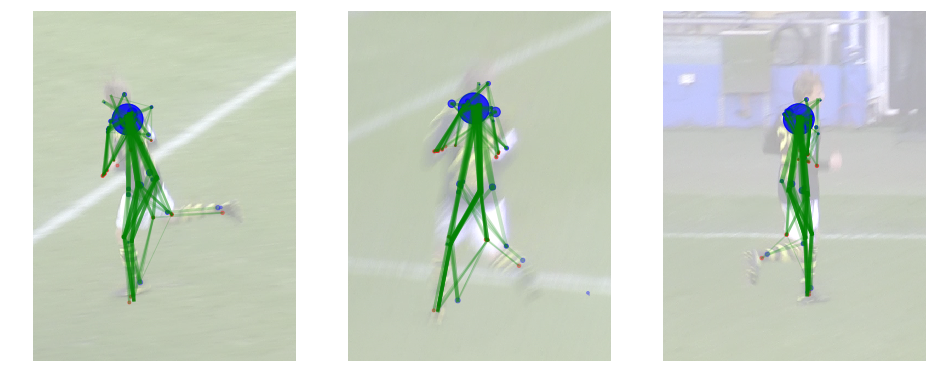

In [10]:
from mvpose.algorithm.graphcut import PBOOST_SMALL, get_unary
import numpy.linalg as la

fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.triangulation.peaks3d_weighted[a][:,0:3]
        candB = Debug.triangulation.peaks3d_weighted[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)

        unaryA = get_unary(Debug.triangulation.peaks3d_weighted[a])[maskA]
        unaryA = PBOOST_SMALL(np.clip(unaryA, a_min=0.00000001, a_max=0.99999999))
        unaryB = get_unary(Debug.triangulation.peaks3d_weighted[b])[maskB]
        unaryB = PBOOST_SMALL(np.clip(unaryB, a_min=0.00000001, a_max=0.99999999))
        
        colorA = ['blue' if q > 0 else 'red' for q in unaryA]
        colorB = ['blue' if q > 0 else 'red' for q in unaryB]
        
        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color=colorA, alpha=0.3, s=np.abs(unaryA) * 50)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color=colorB, alpha=0.3, s=np.abs(unaryB) * 50)
        
        for _a in range(len(ptsA2d)):
            for _b in range(len(ptsB2d)):
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.2)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.2)

        
        
#         ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='black', alpha=0.2)
#         ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='black', alpha=0.2)
        
#         sq_maskA = np.squeeze(maskA[0])
#         sq_maskB = np.squeeze(maskB[0])
#         if len(sq_maskA.shape) == 0:
#             sq_maskA = np.expand_dims(sq_maskA, axis=0)
#         if len(sq_maskB.shape) == 0:
#             sq_maskB = np.expand_dims(sq_maskB, axis=0)
        
#         min_length, max_length = params.sensible_limb_length[lid]
        
#         for _a in sq_maskA:
#             for _b in sq_maskB:
#                 p3dA = candA[_a]
#                 p3dB = candB[_b]
#                 distance = la.norm(p3dA - p3dB)
#                 lstype = '-'
#                 if distance < min_length or distance > max_length:
#                     lstype = ':'
                    
#                 w = W[_a,_b]
#                 Ax,Ay = ptsA2d[_a]
#                 Bx,By = ptsB2d[_b]
#                 if w > 0:
#                     ax.plot([Ax,Bx], [Ay,By], color='green', 
#                             linestyle=lstype, linewidth=w*10, alpha=0.4)
#                 elif w > -99999:
#                     ax.plot([Ax,Bx], [Ay,By], color='red', 
#                             linestyle=lstype, linewidth=-w*10, alpha=0.4)

plt.show()

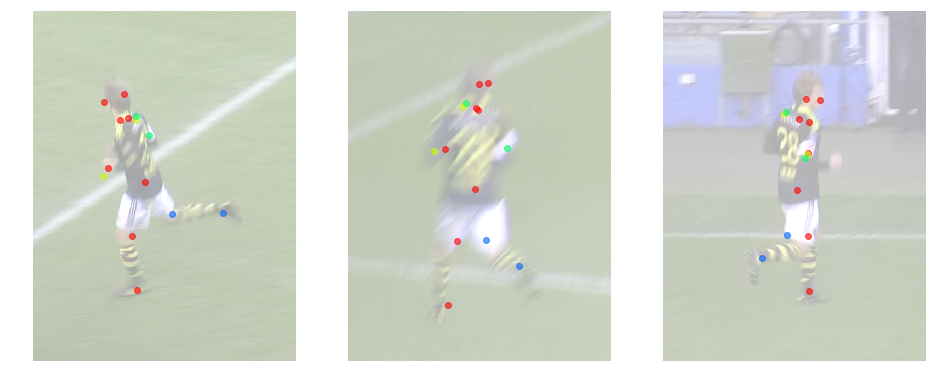

In [11]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
Humans = Debug.graphcut.person_candidates_all 

fig = plt.figure(figsize=(16,12))

colors = cs.lincolor(len(Humans) + 2).astype('float32') / 255

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[pid], alpha=0.6)
    
plt.show()

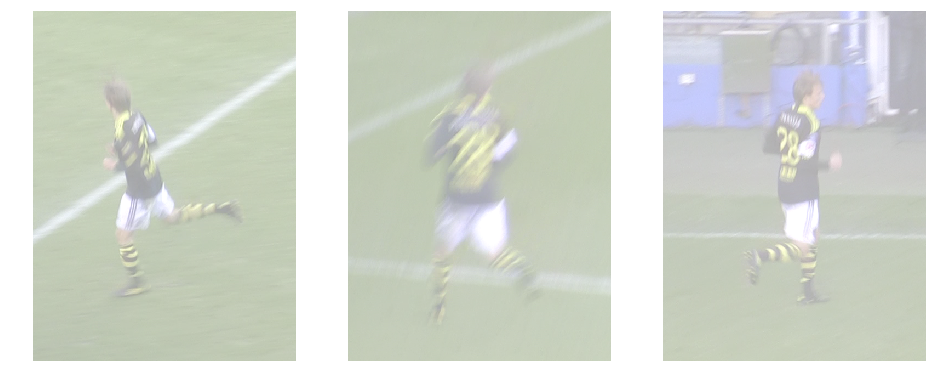

In [12]:
from mvpose.plot.limbs import draw_mscoco_human

Humans = detections
print('Humans', le)

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, colors[pid])
    
plt.show()